# Figure with number of splits and merges

## Imports

In [1]:
import argparse
from pathlib import Path
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pysteps.visualization.spectral import plot_spectrum1d
import geopandas as gpd
from matplotlib.collections import LineCollection
from matplotlib import colors, cm, gridspec, ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from copy import copy
import cmcrameri  # noqa
import palettable  # noqa
import textwrap
import string
import pandas as pd
import xskillscore as xs
import matplotlib.patches as patches
from matplotlib.legend_handler import HandlerTuple
from flox.xarray import xarray_reduce

alphabet = string.ascii_lowercase

import seaborn as sns

Pysteps configuration file found at: /home/users/ritvanen/conda/envs/jupyter/lib/python3.10/site-packages/pysteps/pystepsrc



In [3]:
MEDIANPROPS = dict(linestyle="-", linewidth=2, color="k")
MEANLINEPROPS = dict(linestyle=(0, (1,0.4)), linewidth=2, color="k")
FLIERPROPS = dict(marker="o", markersize=0.3, markerfacecolor="gray", markeredgecolor="gray", rasterized=True)
ZEROLINE_PROPS = dict(linestyle="--", linewidth=1.5, color="gray")


STATE_GROUP_TITLES = {
    "growth": "Growing cells",
    "decay": "Decaying cells",
    "all": "All cells",
}

HUE_CMAP = "cmc.hawaii_r"

PLOT_EXT = "png"

MAX_RR_LIMITS = (-125, 125)
MEAN_RR_LIMITS = (-20, 20)
SUM_RR_LIMITS = (-10, 20)
LIFETIME_LIMITS = (-12, 12)
AREA_LIMITS = (-600, 1000)
COUNT_LIMITS = (0, 20000)
CENTROID_DISTANCE_LIMITS = (0, 30)

MAX_RR_TICK_MULTIPLE = 25
MEAN_RR_TICK_MULTIPLE = 5
SUM_RR_TICK_MULTIPLE = 5
LIFETIME_TICK_MULTIPLE = 2
AREA_TICK_MULTIPLE = 200
COUNT_TICK_MULTIPLE = 1000

MAX_RR_DIFF_TITLE = "Difference in maximum rainfall rate [mm h$^{-1}$]"
MEAN_RR_DIFF_TITLE = "Difference in mean rainfall rate [mm h$^{-1}$]"
SUM_RR_DIFF_TITLE = "Difference in volume rain rate [10$^6$ m$^3$h$^{-1}$]"
LIFETIME_TITLE = "Difference in lifetime [min]"
AREA_TITLE = "Difference in area [km$^2$]"
COUNT_TITLE = "Cell count [10$^3$]"
CENTROID_DISTANCE_TITLE = "Centroid distance [km]"

METHOD_X_LABEL = "Model"

W_PER_METHOD_LT = 1.2
W_PER_METHOD_S = 0.8

FIG_HEIGHT = 6
FIG_WIDTH = 6

HIST_FIG_H = 2.5
HIST_FIG_W = 3

# Cut away saturated values
MAX_RR_LIMIT = 122

# tolerance for zero difference for volume rain rate
SUM_RR_ZERO_TOL = 0.0

def leadtime_to_minutes(x, pos):
    return f"{x * 5:.0f}"

# Load stylefile
plt.style.use(
    "../config/stylefiles/object_figs_article.mplstyle"
)

In [4]:
from addict import Dict
import yaml


def load_yaml_config(path: str):
    """
    Load a YAML config file as an attribute-dictionnary.

    Args:
        path (str): Path to the YAML config file.

    Returns:
        Dict: Configuration loaded.
    """
    with open(path, "r") as f:
        config = Dict(yaml.safe_load(f))
    return config


def save_figs(fig, outpath, name, extensions, subfolder=None):
    if subfolder:
        outpath = outpath / subfolder
        outpath.mkdir(parents=True, exist_ok=True)
    for ext in extensions:
        fig.savefig(outpath / f"{name}.{ext}", bbox_inches="tight")


def create_fig_leadtime_groups(ngroups, nmethods):
    return plt.subplots(
        ncols=ngroups,
        nrows=1,
        # figsize=(W_PER_METHOD_S * N_METHODS, FIG_HEIGHT * len(groups)),
        figsize=(FIG_WIDTH * ngroups, FIG_HEIGHT),
        constrained_layout=True,
        sharey=True,
        squeeze=True
    )

def create_fig_hist(ngroups):
    return plt.subplots(
        ncols=ngroups,
        nrows=1,
        figsize=(HIST_FIG_W*ngroups, HIST_FIG_H),
        constrained_layout=True,
        sharey=True,
    )


def plot_obs_counts(obs_counts, axs, edgecolor=None, hue_cmap=None):
    start = axs.containers[0].get_children()[0].xy[0] - 1
    for i, val in enumerate(obs_counts.values):
        axs.bar(
            start, val, width=axs.containers[-1].get_children()[-1].get_width(),
            align="edge",
            edgecolor=edgecolor or axs.containers[i].get_children()[-1].get_edgecolor(),
            linewidth=axs.containers[i].get_children()[-1].get_linewidth(),
            color=hue_cmap[i] if hue_cmap else axs.containers[i].get_children()[-1].get_facecolor(),
        )
        start += axs.containers[-1].get_children()[-1].get_width()
#     xt = axs.get_xticks()
#     xt = np.append(xt, -1)

#     axs.set_xticks(xt)
#     xtl = axs.get_xticklabels()
#     xtl[-1] = "Target"
#     axs.set_xticklabels(xtl)


def get_labelstr(method, width=10):
    try:
        label = textwrap.fill(conf.methods[method].label, width)
    except:
        label = method
    return label

def set_ax(ax, score_conf, leadtime_limits, leadtime_locator_multiples=[15, 5]):
    """Set axis limits and ticks."""
    if score_conf["limits"] is not None:
        ax.set_ylim(*score_conf["limits"])
    else:
        ax.autoscale(enable=True, axis="y", tight=True)
    if score_conf["ticks"] and len(score_conf["ticks"]) == 3:
        ax.set_yticks(np.arange(*score_conf["ticks"]))
    elif score_conf["ticks"] and len(score_conf["ticks"]) == 2:
        ax.yaxis.set_major_locator(plt.MultipleLocator(score_conf["ticks"][0]))
        ax.yaxis.set_minor_locator(plt.MultipleLocator(score_conf["ticks"][1]))

    if score_conf.get("log_scale"):
        if score_conf["limits"] is not None:
            ax.set_ylim([10 ** score_conf["limits"][0], 10 ** score_conf["limits"][1]])
        else:
            ax.autoscale(enable=True, axis="y", tight=True)

        ax.set_yscale("log")
        ax.yaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=15))
        ax.yaxis.set_minor_locator(plt.NullLocator())

    ax.xaxis.set_major_locator(plt.MultipleLocator(leadtime_locator_multiples[0]))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(leadtime_locator_multiples[1]))
    
    # Add first and last leadtime tick labels
    ax.set_xticks(list(ax.get_xticks()) + leadtime_limits)
    
    ax.set_xlim(*leadtime_limits)
    ax.set_xlabel("Leadtime [min]")

# Read data

## Base data

In [6]:
conf = "../config/swiss-data/plot_metrics_objects_review.yaml"
conf = load_yaml_config(conf)

COLORS_METHODS = {m: conf.methods[m].color for m in conf.methods}

exp_id = conf.exp_id
result_dir = conf.path.result_dir.format(id=exp_id)
OUTPUT_DIR = Path(conf.path.save_dir.format(id=exp_id)) / "figs_article"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

metric = "OBJECTS_ALL"
files = sorted(Path(result_dir).glob(f"*{metric}*.nc"))

path = files[0]

DATASET = xr.open_dataset(path)
DATASET = DATASET.drop_duplicates(dim="sample")


# Change unit of rr sum to 1e6 m^3/h
DATASET["prev_sum_rr"] = DATASET["prev_sum_rr"] * 1e-3
DATASET["obs_sum_rr"] = DATASET["obs_sum_rr"] * 1e-3
DATASET["pred_sum_rr"] = DATASET["pred_sum_rr"] * 1e-3
DATASET["sum_rr_diff"] = DATASET["pred_sum_rr"] - DATASET["obs_sum_rr"]

DATASET["cell_match_obs_sum_rr"] = DATASET["cell_match_obs_sum_rr"] * 1e-3
DATASET["cell_match_pred_sum_rr"] = DATASET["cell_match_pred_sum_rr"] * 1e-3

# Calculate differences
DATASET["max_rr_diff"] = DATASET["pred_max_rr"] - DATASET["obs_max_rr"]
DATASET["mean_rr_diff"] = DATASET["pred_mean_rr"] - DATASET["obs_mean_rr"]
DATASET["lifetime_diff"] = DATASET["pred_lifetime"] - DATASET["obs_lifetime"]
DATASET["area_diff"] = DATASET["pred_area"] - DATASET["obs_area"]

# Maximum area in track
DATASET["max_prev_area"] = DATASET["prev_area"].max(dim="prev_time", skipna=True) 
DATASET["max_obs_area"] = DATASET["obs_area"].max(dim="leadtime", skipna=True) 

DATASET["max_area"] = (["sample", "track"], np.nanmax([DATASET["max_prev_area"].values, DATASET["max_obs_area"].values], axis=0))

# Track lifetime
DATASET["lifetime_prev"] = DATASET["prev_mean_rr"].count(dim="prev_time")
DATASET["lifetime_full"] = DATASET["lifetime_prev"] + DATASET["obs_lifetime"]

# Maximum RVR in track
DATASET["track_max_prev_rr"] = DATASET["prev_sum_rr"].max(dim="prev_time", skipna=True)
DATASET["track_max_obs_rr"] = DATASET["obs_sum_rr"].max(dim="leadtime", skipna=True)
DATASET["track_max_pred_rr"] = DATASET["pred_sum_rr"].max(dim="leadtime", skipna=True)
DATASET["track_argmax_obs_rr"] = DATASET["obs_sum_rr"].fillna(-1000).argmax(dim="leadtime", skipna=True).where(
    DATASET["track_max_obs_rr"] > 0)

# Minimum RVR in track
DATASET["track_min_prev_rr"] = DATASET["prev_sum_rr"].min(dim="prev_time", skipna=True)
DATASET["track_min_obs_rr"] = DATASET["obs_sum_rr"].min(dim="leadtime", skipna=True)
DATASET["track_min_pred_rr"] = DATASET["pred_sum_rr"].min(dim="leadtime", skipna=True)

# General variables
DATASET = DATASET.where(DATASET.method.isin(conf.legend_order))
N_METHODS = np.unique(DATASET.method.values).size
METHODS = np.unique(DATASET.method.values)

sorter = np.argsort(np.array(conf.legend_order))

DATASET_BASE = DATASET.copy()
DATASET_BASE

<xarray.Dataset> Size: 20GB
Dimensions:                  (sample: 11164, leadtime: 12, method: 4, cell: 93,
                              track: 134, prev_time: 5)
Coordinates:
  * method                   (method) <U23 368B 'lcnn-diff-rmse-31012024' ......
  * leadtime                 (leadtime) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * prev_time                (prev_time) int64 40B -4 -3 -2 -1 0
  * track                    (track) float64 1kB 1.0 2.0 3.0 ... 133.0 134.0
  * cell                     (cell) int64 744B 0 1 2 3 4 5 ... 87 88 89 90 91 92
  * sample                   (sample) <U19 848kB '2023-06-03 16:20:00' ... '2...
Data variables: (12/61)
    cell_match_hits          (sample, leadtime, method) float64 4MB 46.0 ... 0.0
    cell_match_misses        (sample, leadtime, method) float64 4MB 5.0 ... 12.0
    cell_match_false_alarms  (sample, leadtime, method) float64 4MB 8.0 ... 2.0
    cell_match_dist          (sample, leadtime, method, cell) float64 399MB 1...
    cell_match_obs_sum_rr    (sample, leadtime, method, cell) float64 399MB 0...
    cell_match_pred_sum_rr   (sample, leadtime, method, cell) float64 399MB 0...
    ...                       ...
    track_max_obs_rr         (sample, track, method) float64 48MB 0.2186 ... nan
    track_max_pred_rr        (sample, track, method) float64 48MB 0.3979 ... nan
    track_argmax_obs_rr      (sample, track, method) float64 48MB 0.0 ... nan
    track_min_prev_rr        (sample, track, method) float64 48MB 0.4815 ... nan
    track_min_obs_rr         (sample, track, method) float64 48MB 0.2186 ... nan
    track_min_pred_rr        (sample, track, method) float64 48MB 0.2176 ... nan

## Cell state

In [7]:
ds_ = DATASET.copy()

# State according to derivative definition
derivative_at_t0 = xr.concat([
    DATASET["prev_sum_rr"].sel(prev_time=[-2, -1, 0]).rename({"prev_time": "leadtime"}), 
    DATASET["obs_sum_rr"].sel(leadtime=[1, 2,])
], dim="leadtime").differentiate("leadtime").sel(leadtime=0)

num_point_in_derivative = xr.concat([
    DATASET["prev_sum_rr"].sel(prev_time=[-2, -1, 0]).rename({"prev_time": "leadtime"}), 
    DATASET["obs_sum_rr"].sel(leadtime=[1, 2,])
], dim="leadtime").count(dim="leadtime")

ds_["obs_derivative_at_t0"] = derivative_at_t0
ds_["num_points_in_obs_derivative"] = num_point_in_derivative

growth_cond = derivative_at_t0 > 0
decay_cond = (
    ((derivative_at_t0) < 0) | 
    ((ds_["track_max_prev_rr"] > 0) & (ds_["prev_sum_rr"].sel(prev_time=0) > 0) & (derivative_at_t0.isnull()))
)
stable_cond = (
    (np.abs(derivative_at_t0) == 0)
    & ((ds_["track_max_prev_rr"] > 0) & (ds_["track_max_obs_rr"] > 0))
)
ds_["state"] = xr.ones_like(ds_["track_max_prev_rr"]) * np.nan
ds_["state"] = ds_["state"].where(~growth_cond, "growth")
ds_["state"] = ds_["state"].where(~decay_cond, "decay")
ds_["state"] = ds_["state"].where(~stable_cond, "stable")

# As integer for confusion matrix
ds_["state_int"] = xr.ones_like(ds_["track_max_prev_rr"]) * np.nan
ds_["state_int"] = ds_["state_int"].where(~growth_cond, 1)
ds_["state_int"] = ds_["state_int"].where(~decay_cond, 2)
ds_["state_int"] = ds_["state_int"].where(~stable_cond, 3)

# Predicted state according to derivative definition
# Predicted state per track
derivative_pred_at_t0 = xr.concat([
    DATASET["prev_sum_rr"].sel(prev_time=[-2, -1, 0]).rename({"prev_time": "leadtime"}), 
    DATASET["pred_sum_rr"].sel(leadtime=[1, 2,])
], dim="leadtime").differentiate("leadtime").sel(leadtime=0)

num_point_in_pred_derivative = xr.concat([
    DATASET["prev_sum_rr"].sel(prev_time=[-2, -1, 0]).rename({"prev_time": "leadtime"}), 
    DATASET["pred_sum_rr"].sel(leadtime=[1, 2,])
], dim="leadtime").count(dim="leadtime")

ds_["pred_derivative_at_t0"] = derivative_pred_at_t0
ds_["num_points_in_pred_derivative"] = num_point_in_pred_derivative
growth_cond_pred = derivative_pred_at_t0 > 0
decay_cond_pred = (
    (derivative_pred_at_t0 < 0) | 
    ((ds_["track_max_prev_rr"] > 0) &  (ds_["prev_sum_rr"].sel(prev_time=0) > 0) & (derivative_pred_at_t0.isnull()))
)
stable_cond_pred = (
    (np.abs(derivative_pred_at_t0) == 0) & 
    ((ds_["track_max_prev_rr"] > 0) & (ds_["track_max_pred_rr"] > 0))
)

ds_["state_pred"] = xr.ones_like(ds_["track_max_prev_rr"]) * np.nan
ds_["state_pred"] = ds_["state_pred"].where(~growth_cond_pred, "growth")
ds_["state_pred"] = ds_["state_pred"].where(~decay_cond_pred, "decay")
ds_["state_pred"] = ds_["state_pred"].where(~stable_cond_pred, "stable")

# As integer for confusion matrix
ds_["state_pred_int"] = xr.ones_like(ds_["track_max_prev_rr"]) * np.nan
ds_["state_pred_int"] = ds_["state_pred_int"].where(~growth_cond_pred, 1)
ds_["state_pred_int"] = ds_["state_pred_int"].where(~decay_cond_pred, 2)
ds_["state_pred_int"] = ds_["state_pred_int"].where(~stable_cond_pred, 3)

DATASET_CELL_STATE = ds_.copy()

DATASET_CELL_STATE

<xarray.Dataset> Size: 20GB
Dimensions:                        (sample: 11164, leadtime: 12, method: 4,
                                    cell: 93, track: 134, prev_time: 5)
Coordinates:
  * method                         (method) <U23 368B 'lcnn-diff-rmse-3101202...
  * leadtime                       (leadtime) int64 96B 1 2 3 4 5 ... 9 10 11 12
  * prev_time                      (prev_time) int64 40B -4 -3 -2 -1 0
  * track                          (track) float64 1kB 1.0 2.0 ... 133.0 134.0
  * cell                           (cell) int64 744B 0 1 2 3 4 ... 89 90 91 92
  * sample                         (sample) <U19 848kB '2023-06-03 16:20:00' ...
Data variables: (12/69)
    cell_match_hits                (sample, leadtime, method) float64 4MB 46....
    cell_match_misses              (sample, leadtime, method) float64 4MB 5.0...
    cell_match_false_alarms        (sample, leadtime, method) float64 4MB 8.0...
    cell_match_dist                (sample, leadtime, method, cell) float64 399MB ...
    cell_match_obs_sum_rr          (sample, leadtime, method, cell) float64 399MB ...
    cell_match_pred_sum_rr         (sample, leadtime, method, cell) float64 399MB ...
    ...                             ...
    state                          (sample, track, method) object 48MB 'decay...
    state_int                      (sample, track, method) float64 48MB 2.0 ....
    pred_derivative_at_t0          (sample, track, method) float64 48MB -0.07...
    num_points_in_pred_derivative  (sample, track, method) int64 48MB 5 5 ... 0
    state_pred                     (sample, track, method) object 48MB 'decay...
    state_pred_int                 (sample, track, method) float64 48MB 2.0 ....

In [8]:
n_leadtimes = DATASET_BASE.leadtime.values.size

# Number of splits and merges

In [9]:
ds_obs = DATASET[["obs_merged", "obs_from_split"]].sum(dim=["track", "sample"]).to_dataframe().reset_index()
ds_pred = DATASET[["pred_merged", "pred_from_split"]].sum(dim=["track", "sample"]).to_dataframe().reset_index()

track_exists_cond = (DATASET["track_max_prev_rr"] > 0) & ((DATASET["prev_sum_rr"].sel(prev_time=0) > 0))

ds_obs_count = (DATASET["obs_area"] > 0).sum(dim=["track", "sample"]).to_dataframe(name="obs_total_count").reset_index()
ds_pred_count = (DATASET["pred_area"] > 0).sum(dim=["track", "sample"]).to_dataframe(name="pred_total_count").reset_index()

ds_obs_split_or_merge = ((DATASET["obs_merged"].fillna(0) + DATASET["obs_from_split"].fillna(0)) > 0).sum(dim=["track", "sample"]).to_dataframe(name="obs_split_or_merge").reset_index()
ds_pred_split_or_merge = ((DATASET["pred_merged"].fillna(0) + DATASET["pred_from_split"].fillna(0)) > 0).sum(dim=["track", "sample"]).to_dataframe(name="pred_split_or_merge").reset_index()

ds_obs_split_and_merge = ((DATASET["obs_merged"].fillna(0) + DATASET["obs_from_split"].fillna(0)) > 1).sum(dim=["track", "sample"]).to_dataframe(name="obs_split_and_merge").reset_index()
ds_pred_split_and_merge = ((DATASET["pred_merged"].fillna(0) + DATASET["pred_from_split"].fillna(0)) > 1).sum(dim=["track", "sample"]).to_dataframe(name="pred_split_and_merge").reset_index()

df = ds_obs.merge(ds_pred).merge(ds_obs_split_or_merge).merge(ds_pred_split_or_merge).merge(ds_obs_split_and_merge).merge(ds_pred_split_and_merge).merge(ds_obs_count).merge(ds_pred_count)

# Define number of only merges and only splits
df["obs_only_merge"] = df["obs_merged"] - df["obs_split_and_merge"]
df["pred_only_merge"] = df["pred_merged"] - df["pred_split_and_merge"]

df["obs_only_split"] = df["obs_from_split"] - df["obs_split_and_merge"]
df["pred_only_split"] = df["pred_from_split"] - df["pred_split_and_merge"]

# This plotted with colors: cells with no merge or split
df["obs_plot_no_merge_split"] = df["obs_total_count"] - df["obs_split_or_merge"]
df["pred_plot_no_merge_split"] = df["pred_total_count"] - df["pred_split_or_merge"]

# Plotted on top with gray: cells with only splits
df["obs_plot_only_split"] = df["obs_only_split"] + df["obs_plot_no_merge_split"]
df["pred_plot_only_split"] = df["pred_only_split"] + df["pred_plot_no_merge_split"]

# Plotted on top with white: cells with only merges
df["obs_plot_only_merge"] = df["obs_only_merge"] + df["obs_plot_only_split"]
df["pred_plot_only_merge"] = df["pred_only_merge"] + df["pred_plot_only_split"]

# Plotted last with black: cells with both merges and splits
df["obs_plot_both_merge_split"] = df["obs_split_and_merge"] + df["obs_plot_only_merge"]
df["pred_plot_both_merge_split"] = df["pred_split_and_merge"] + df["pred_plot_only_merge"]


# Contingency table for metrics

cell_merge_nowcast = DATASET["pred_merged"] == True
cell_merge_obs = DATASET["obs_merged"] == True

cell_merge_nowcast = cell_merge_nowcast.where(track_exists_cond, 2)
cell_merge_obs = cell_merge_obs.where(track_exists_cond, 2)

contingency_merge = xs.Contingency(
    cell_merge_obs, 
    cell_merge_nowcast, 
    np.array([0, 0.5, 1.0]), 
    np.array([0, 0.5, 1.0]), 
    dim=["sample", "track"],
)
contingency_merge.table

cell_split_nowcast = DATASET["pred_from_split"] == True
cell_split_obs = DATASET["obs_from_split"] == True

cell_split_nowcast = cell_split_nowcast.where(track_exists_cond, 2)
cell_split_obs = cell_split_obs.where(track_exists_cond, 2)

contingency_split = xs.Contingency(
    cell_split_obs, 
    cell_split_nowcast, 
    np.array([0, 0.5, 1.0]), 
    np.array([0, 0.5, 1.0]), 
    dim=["sample", "track"],
)
contingency_split.table


<xarray.DataArray 'histogram_observations_forecasts' (leadtime: 12, method: 4,
                                                      observations_category: 2,
                                                      forecasts_category: 2)> Size: 2kB
array([[[[141903,   4381],
         [  5642,   4282]],

        [[144137,   2147],
         [  8236,   1688]],

        [[143315,   2969],
         [  6726,   3198]],

        [[143091,   3193],
         [  6643,   3281]]],


       [[[143300,   4164],
         [  6758,   1986]],

        [[144926,   2538],
         [  7714,   1030]],

        [[145235,   2229],
...
         [  2994,    250]],

        [[152520,    444],
         [  3210,     34]],

        [[152582,    382],
         [  3213,     31]]],


       [[[151619,   1693],
         [  2697,    199]],

        [[150377,   2935],
         [  2635,    261]],

        [[152943,    369],
         [  2868,     28]],

        [[152990,    322],
         [  2870,     26]]]])
Coordinates:
  * leadtime                      (leadtime) int64 96B 1 2 3 4 5 ... 9 10 11 12
  * method                        (method) <U23 368B 'lcnn-diff-rmse-31012024...
    observations_category_bounds  (observations_category) <U10 80B '[0.0, 0.5...
    forecasts_category_bounds     (forecasts_category) <U10 80B '[0.0, 0.5)' ...
  * observations_category         (observations_category) int64 16B 1 2
  * forecasts_category            (forecasts_category) int64 16B 1 2

In [10]:
df[["method", "leadtime", "obs_merged", "obs_from_split", "obs_split_and_merge", "obs_split_or_merge", "obs_total_count", "pred_total_count"]]

,method,leadtime,obs_merged,obs_from_split,obs_split_and_merge,obs_split_or_merge,obs_total_count,pred_total_count
0,lcnn-diff-rmse-31012024,1,9541.0,9924.0,4935,14530,123683,130554
1,extrapolation,1,9541.0,9924.0,4935,14530,123683,150715
2,linda,1,9541.0,9924.0,4935,14530,123683,135269
3,sprog,1,9541.0,9924.0,4935,14530,123683,127332
4,lcnn-diff-rmse-31012024,2,8484.0,8744.0,4299,12929,100848,114376
5,extrapolation,2,8484.0,8744.0,4299,12929,100848,147693
6,linda,2,8484.0,8744.0,4299,12929,100848,123903
7,sprog,2,8484.0,8744.0,4299,12929,100848,106628
8,lcnn-diff-rmse-31012024,3,7635.0,7793.0,3818,11610,83737,101713
9,extrapolation,3,7635.0,7793.0,3818,11610,83737,145723


## Figure in absolute numbers with contingency metrics

In [11]:

fig = plt.figure(layout="constrained", figsize=(12, 12))

axs = fig.subplot_mosaic([
        [".", "counts", "counts", "counts", "counts", "."],
        ["CSI_merge", "CSI_merge", "POD_merge","POD_merge", "FAR_merge","FAR_merge"],
        ["CSI_split", "CSI_split", "POD_split","POD_split", "FAR_split","FAR_split"],
    ], 
    width_ratios=[0.2, 0.1, 0.15, 0.15, 0.1, 0.2],
    height_ratios=[0.5, 0.5, 0.5],
    # gridspec_kw={'wspace': 0.0, "w_pad": 0}
)

df.sort_values(
    by=["method", "leadtime"],
    key=lambda x: sorter[
        np.searchsorted(np.array(conf.legend_order), x, sorter=sorter)
    ] if isinstance(x.values[0], str) else x,
    inplace=True,
)

g_both_split_merge = sns.barplot(
    ax=axs["counts"], 
    data=df, 
    x="method", 
    hue="leadtime", 
    y="pred_plot_both_merge_split", 
    palette=["k"]*n_leadtimes, 
    edgecolor="black", 
    linewidth=0.5, 
    legend=False,
)
# Plot target counts
plot_obs_counts(df.loc[df.method=="extrapolation"]["obs_plot_both_merge_split"], axs["counts"], hue_cmap=["k"]*n_leadtimes, edgecolor="black")


g_obs_total_count = sns.barplot(
    ax=axs["counts"], 
    data=df, 
    x="method", 
    y="pred_plot_only_merge", 
    hue="leadtime", 
    palette=["w"]*n_leadtimes, 
    edgecolor="black", 
    linewidth=0.5, 
    legend=False,
)
# Plot target counts
plot_obs_counts(df.loc[df.method=="extrapolation"]["obs_plot_only_merge"], axs["counts"], hue_cmap=["w"]*n_leadtimes, edgecolor="black")

# Merged and split cells
g_pred_merged_split = sns.barplot(
    ax=axs["counts"], 
    data=df, 
    x="method", 
    hue="leadtime", 
    y="pred_plot_only_split", 
    palette=["tab:gray"]*n_leadtimes, 
    edgecolor="black", 
    linewidth=0.5, 
    legend=False,
)
# Plot target counts
plot_obs_counts(df.loc[df.method=="extrapolation"]["obs_plot_only_split"], axs["counts"], hue_cmap=["tab:gray"]*n_leadtimes, edgecolor="black")
    
g_pred_merged = sns.barplot(
    ax=axs["counts"], 
    data=df, 
    x="method", 
    y="pred_plot_no_merge_split",
    hue="leadtime", 
    palette=HUE_CMAP, 
    edgecolor="black", 
    linewidth=0.5, 
    legend="full"
)
g_pred_merged.axes.get_legend().remove()
# Plot target counts
plot_obs_counts(df.loc[df.method=="extrapolation"]["obs_plot_no_merge_split"], axs["counts"], hue_cmap=sns.color_palette(HUE_CMAP, n_colors=n_leadtimes), edgecolor="black")

axs["counts"].set_title(f"(a) Cell counts")
axs["counts"].set_xticklabels([get_labelstr(l.get_text()) for l in axs["counts"].get_xticklabels()])
axs["counts"].set_autoscale_on(False)
axs["counts"].set_ylim(0, 225e3)
axs["counts"].set_ylabel(COUNT_TITLE)
# ax.set_ylim(LIFETIME_LIMITS)
# ax.yaxis.set_major_locator(ticker.MultipleLocator(LIFETIME_TICK_MULTIPLE))
axs["counts"].yaxis.set_major_locator(ticker.MultipleLocator(25e3))
axs["counts"].yaxis.set_minor_locator(ticker.MultipleLocator(5e3))
axs["counts"].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{x / 1000:.0f}"))
axs["counts"].grid(which="major", axis="y")
axs["counts"].grid(which="minor", axis="y", alpha=0.2)
axs["counts"].set_autoscale_on(False)
axs["counts"].set_xlabel(METHOD_X_LABEL)

h, l = axs["counts"].get_legend_handles_labels()
l1 = fig.legend(
    h,
    [leadtime_to_minutes((int(s)), 0) for s in l],
    title="Leadtime [min]",
    bbox_to_anchor=(0.8, 0.8),
    loc="center left",
    frameon=True,
    bbox_transform=fig.transFigure,
    ncols=1,
)
fig.add_artist(l1)

# Make legend for hits, misses, false alarms, correct negatives labels
palette_hue = sns.color_palette(HUE_CMAP, n_leadtimes)
hits_patch = [patches.Patch(facecolor=c, edgecolor=c, label="No split or merge") for c in palette_hue]

split_patch = patches.Patch(facecolor="tab:gray", edgecolor="tab:gray", label="Split")
merge_patch = patches.Patch(facecolor="white", edgecolor="k", label="Merge")
both_split_merge_patch = patches.Patch(facecolor="k", edgecolor="tab:gray", label="Both split and merge")

other_patches = [split_patch, merge_patch, both_split_merge_patch]

leg = fig.legend(
    handles=[hits_patch, *other_patches], 
    labels=["No split or merge", *[p.get_label() for p in other_patches]], 
    handler_map={list: HandlerTuple(ndivide=None, pad=0)},
    ncols=1,
    bbox_to_anchor=(0.8, 0.95),
    loc="center left",
    frameon=True,
    bbox_transform=fig.transFigure,
)

metrics = ["CSI", "POD", "FAR"]

dfs_merge = {
    "CSI": contingency_merge.threat_score(),
    "POD": contingency_merge.hit_rate(),
    "FAR": contingency_merge.false_alarm_ratio(),
}
dfs_split = {
    "CSI": contingency_split.threat_score(),
    "POD": contingency_split.hit_rate(),
    "FAR": contingency_split.false_alarm_ratio(),
}

for i, metric in enumerate(metrics):
    df_ = dfs_merge[metric]
    # Change leadtime to minutes
    df_["leadtime"] = df_["leadtime"] * 5
    for model in conf.legend_order:
        df_.sel(dict(method=model)).plot.line(
            ax=axs[f"{metric}_merge"],
            x="leadtime",
            color=conf.methods[model]["color"],
            label=conf.methods[model]["label"],
            linestyle=conf.methods[model]["linestyle"],
        )
    set_ax(axs[f"{metric}_merge"], conf.metric_conf[metric], [5, 60], conf.leadtime_locator_multiples)
    axs[f"{metric}_merge"].set_ylabel(conf.metric_conf[metric]["label"])
    axs[f"{metric}_merge"].set_title(f'({alphabet[1+i]}) Merges: {conf.metric_conf[metric]["full_name"]}', color=plt.rcParams["axes.titlecolor"])
    axs[f"{metric}_merge"].grid(which="both", axis="both")
    axs[f"{metric}_merge"].legend()
    
    df_ = dfs_split[metric]
    # Change leadtime to minutes
    df_["leadtime"] = df_["leadtime"] * 5
    for model in conf.legend_order:
        df_.sel(dict(method=model)).plot.line(
            ax=axs[f"{metric}_split"],
            x="leadtime",
            color=conf.methods[model]["color"],
            label=conf.methods[model]["label"],
            linestyle=conf.methods[model]["linestyle"],
        )
    set_ax(axs[f"{metric}_split"], conf.metric_conf[metric], [5, 60], conf.leadtime_locator_multiples)
    axs[f"{metric}_split"].set_ylabel(conf.metric_conf[metric]["label"])
    axs[f"{metric}_split"].set_title(f'({alphabet[1 + len(metrics) + i]}) Splits: {conf.metric_conf[metric]["full_name"]}', color=plt.rcParams["axes.titlecolor"])
    axs[f"{metric}_split"].grid(which="both", axis="both")
    axs[f"{metric}_split"].legend()


outputname = "split_merge_contingency"
save_figs(fig, OUTPUT_DIR, outputname, conf.output_formats)


/home/users/ritvanen/conda/envs/jupyter/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/users/ritvanen/conda/envs/jupyter/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/users/ritvanen/conda/envs/jupyter/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_

## Figure in fractions

/home/users/ritvanen/conda/envs/jupyter/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/users/ritvanen/conda/envs/jupyter/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/users/ritvanen/conda/envs/jupyter/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_

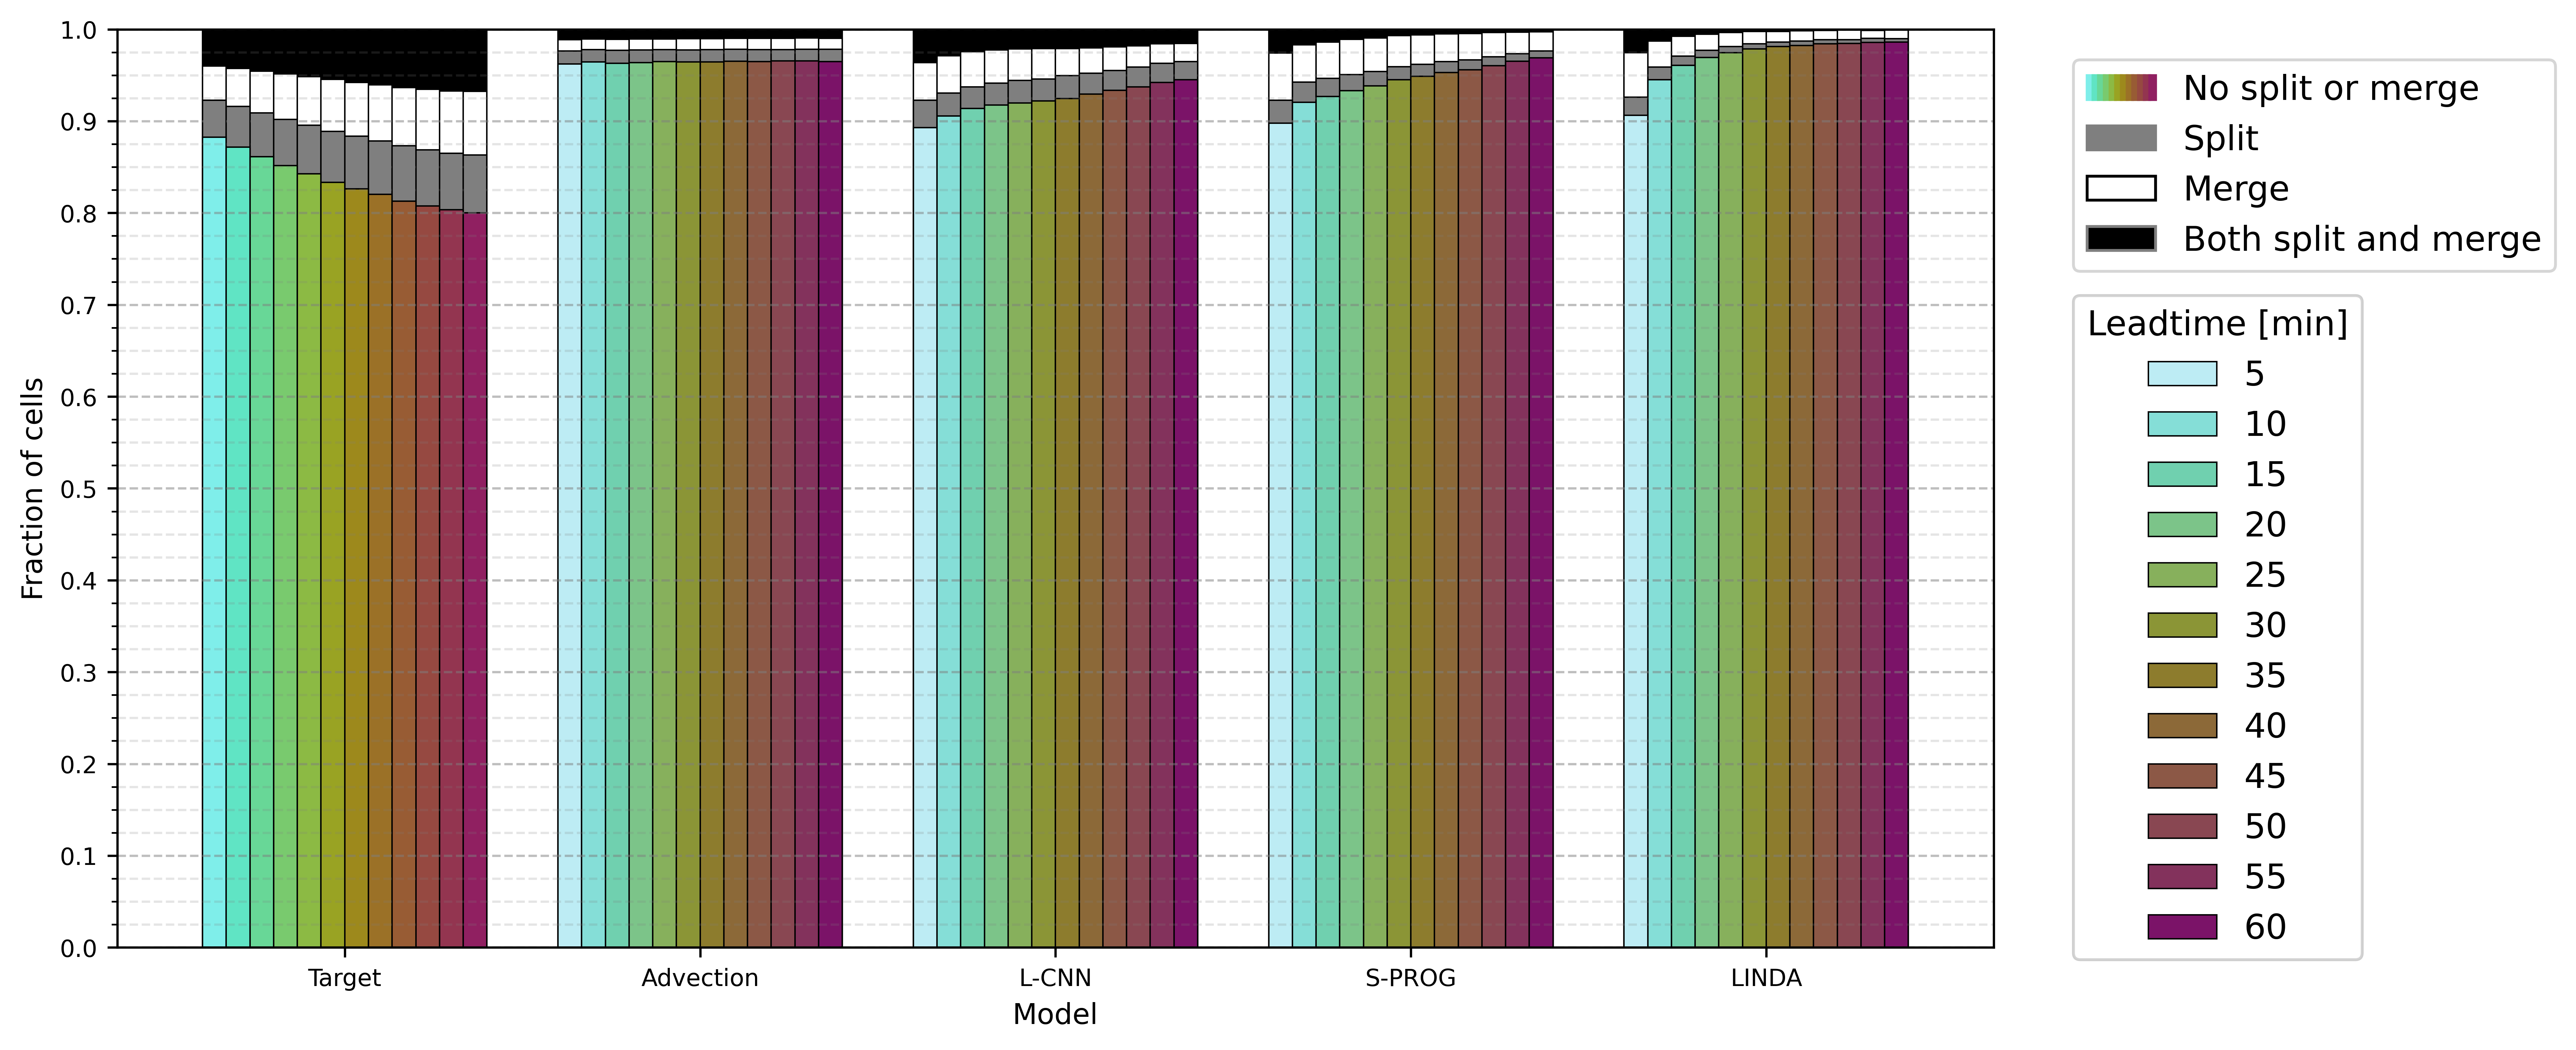

In [16]:
fig = plt.figure(layout="constrained", figsize=(12, 5))

axs = fig.subplot_mosaic([
        ["counts", "."],
    ], 
    width_ratios=[0.8, 0.2],
    # height_ratios=[0.5, 0.5, 0.5],
    # gridspec_kw={'wspace': 0.0, "w_pad": 0}
)

df_pct = df.copy()
df_pct["pred_plot_only_merge"] /= df_pct["pred_plot_both_merge_split"]
df_pct["pred_plot_only_split"] /= df_pct["pred_plot_both_merge_split"]
df_pct["pred_plot_no_merge_split"] /= df_pct["pred_plot_both_merge_split"]
df_pct["pred_plot_both_merge_split"] /= df_pct["pred_plot_both_merge_split"]

df_pct["obs_plot_only_merge"] /= df_pct["obs_plot_both_merge_split"]
df_pct["obs_plot_only_split"] /= df_pct["obs_plot_both_merge_split"]
df_pct["obs_plot_no_merge_split"] /= df_pct["obs_plot_both_merge_split"]
df_pct["obs_plot_both_merge_split"] /= df_pct["obs_plot_both_merge_split"]


df_pct.sort_values(
    by=["method", "leadtime"],
    key=lambda x: sorter[
        np.searchsorted(np.array(conf.legend_order), df.method.values, sorter=sorter)
    ] if isinstance(x.values[0], str) else x,
    inplace=True,
)

g_both_split_merge = sns.barplot(
    ax=axs["counts"], 
    data=df_pct, 
    x="method", 
    hue="leadtime", 
    y="pred_plot_both_merge_split", 
    palette=["k"]*n_leadtimes, 
    edgecolor="black", 
    linewidth=0.5, 
    legend=False,
)
# Plot target counts
plot_obs_counts(df_pct.loc[df_pct.method=="extrapolation"]["obs_plot_both_merge_split"], axs["counts"], hue_cmap=["k"]*n_leadtimes, edgecolor="black")


g_obs_total_count = sns.barplot(
    ax=axs["counts"], 
    data=df_pct, 
    x="method", 
    y="pred_plot_only_merge", 
    hue="leadtime", 
    palette=["w"]*n_leadtimes, 
    edgecolor="black", 
    linewidth=0.5, 
    legend=False,
)
# Plot target counts
plot_obs_counts(df_pct.loc[df_pct.method=="extrapolation"]["obs_plot_only_merge"], axs["counts"], hue_cmap=["w"]*n_leadtimes, edgecolor="black")

# Merged and split cells
g_pred_merged_split = sns.barplot(
    ax=axs["counts"], 
    data=df_pct, 
    x="method", 
    hue="leadtime", 
    y="pred_plot_only_split", 
    palette=["tab:gray"]*n_leadtimes, 
    edgecolor="black", 
    linewidth=0.5, 
    legend=False,
)
# Plot target counts
plot_obs_counts(df_pct.loc[df_pct.method=="extrapolation"]["obs_plot_only_split"], axs["counts"], hue_cmap=["tab:gray"]*n_leadtimes, edgecolor="black")
    
g_pred_merged = sns.barplot(
    ax=axs["counts"], 
    data=df_pct, 
    x="method", 
    y="pred_plot_no_merge_split",
    hue="leadtime", 
    palette=HUE_CMAP, 
    edgecolor="black", 
    linewidth=0.5, 
    legend="full",
    zorder=1,
)
g_pred_merged.axes.get_legend().remove()
# Plot target counts
plot_obs_counts(df_pct.loc[df_pct.method=="extrapolation"]["obs_plot_no_merge_split"], axs["counts"], hue_cmap=sns.color_palette(HUE_CMAP, n_colors=n_leadtimes), edgecolor="black")

# axs["counts"].set_title(f"(a) Cell counts")
axs["counts"].set_xticklabels([get_labelstr(l.get_text()) for l in axs["counts"].get_xticklabels()])
axs["counts"].set_autoscale_on(False)
axs["counts"].set_ylim(0, 1)
# axs["counts"].set_ylabel(COUNT_TITLE)
axs["counts"].set_ylabel("Fraction of cells")
# ax.set_ylim(LIFETIME_LIMITS)
# ax.yaxis.set_major_locator(ticker.MultipleLocator(LIFETIME_TICK_MULTIPLE))
axs["counts"].yaxis.set_major_locator(ticker.MultipleLocator(0.1))
axs["counts"].yaxis.set_minor_locator(ticker.MultipleLocator(0.025))
# axs["counts"].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{x / 1000:.0f}"))
axs["counts"].grid(which="major", axis="y", zorder=10)
axs["counts"].grid(which="minor", axis="y", alpha=0.2, zorder=10)
axs["counts"].set_autoscale_on(False)
axs["counts"].set_xlabel(METHOD_X_LABEL)

h, l = axs["counts"].get_legend_handles_labels()
l1 = fig.legend(
    h,
    [leadtime_to_minutes((int(s)), 0) for s in l],
    title="Leadtime [min]",
    bbox_to_anchor=(0.83, 0.4),
    loc="center left",
    frameon=True,
    bbox_transform=fig.transFigure,
    ncols=1,
    fontsize="large",
    title_fontsize="large",
)
fig.add_artist(l1)

# Make legend for hits, misses, false alarms, correct negatives labels
palette_hue = sns.color_palette(HUE_CMAP, n_leadtimes)
hits_patch = [patches.Patch(facecolor=c, edgecolor=c, label="No split or merge") for c in palette_hue]

split_patch = patches.Patch(facecolor="tab:gray", edgecolor="tab:gray", label="Split")
merge_patch = patches.Patch(facecolor="white", edgecolor="k", label="Merge")
both_split_merge_patch = patches.Patch(facecolor="k", edgecolor="tab:gray", label="Both split and merge")

other_patches = [split_patch, merge_patch, both_split_merge_patch]

leg = fig.legend(
    handles=[hits_patch, *other_patches], 
    labels=["No split or merge", *[p.get_label() for p in other_patches]], 
    handler_map={list: HandlerTuple(ndivide=None, pad=0)},
    ncols=1,
    bbox_to_anchor=(0.83, 0.85),
    loc="center left",
    frameon=True,
    bbox_transform=fig.transFigure,
    fontsize="large",
    title_fontsize="large",
)

# Set target ticklabels
xt = axs["counts"].get_xticks()
xt = np.append(xt, -1)

axs["counts"].set_xticks(xt)
xtl = axs["counts"].get_xticklabels()
xtl[-1] = "Target"
axs["counts"].set_xticklabels(xtl)

outputname = "split_merge_counts"
df_pct.to_csv(f"{OUTPUT_DIR}/{outputname}.csv")
save_figs(fig, OUTPUT_DIR, outputname, conf.output_formats)
